In [4]:
import os

# 1. Create a directory for the data
if not os.path.exists('data'):
    os.makedirs('data')

# 2. Download the zip file (using a reliable mirror for the NASA dataset)
!#wget https://data.nasa.gov/docs/legacy/CMAPSSData.zip -O data/CMAPSSData.zip

# 3. Unzip it
#!unzip -o data/CMAPSSData.zip -d data/

#print("Data downloaded and extracted!")

In [158]:
# The dataset has 26 columns
# 1. Unit Number (Which engine is it?)
# 2. Time Cycles (How long has it been running?)
# 3-5. Operational Settings (Altitude, Speed, etc.)
# 6-26. Sensor Readings (s1 to s21)

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

print(col_names)

['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [159]:
import pandas as pd

data_df = pd.read_csv('data/train_FD001.txt', sep=r'\s+', header=None, names=col_names)

print("Training data shape:", data_df.shape)
data_df.head()

Training data shape: (20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [161]:
col_names

['unit_nr',
 'time_cycles',
 'setting_1',
 'setting_2',
 'setting_3',
 's_1',
 's_2',
 's_3',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_20',
 's_21']

In [166]:
max_value_cycle = data_df.groupby('unit_nr')['time_cycles'].max()

# Convert Series to DataFrame with a specific column name
max_cycle_df = max_value_cycle.to_frame(name='max_cycle')
max_cycle_df.head()

,max_cycle
unit_nr,
1,192
2,287
3,179
4,189
5,269


In [168]:
data_df = data_df.merge(max_cycle_df, left_on='unit_nr', right_index=True)
data_df.head()       

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192


In [169]:
data_df['RUL'] = (
    data_df['max_cycle'] - data_df['time_cycles']
)
data_df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [170]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [172]:
train_df = data_df[setting_names].copy()
train_df.head(200)

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2,4,0.0035,-0.0004,100.0,518.67,641.68,1584.15,1396.08,14.62,...,522.49,2387.93,8140.44,8.4018,0.03,391,2388,100.0,39.13,23.5027
196,2,5,0.0005,0.0004,100.0,518.67,641.73,1579.03,1402.52,14.62,...,522.27,2387.94,8136.67,8.3867,0.03,390,2388,100.0,39.18,23.4234
197,2,6,-0.0010,0.0004,100.0,518.67,641.30,1577.50,1396.76,14.62,...,522.80,2387.99,8133.65,8.3800,0.03,392,2388,100.0,39.15,23.4270
198,2,7,0.0001,-0.0002,100.0,518.67,642.03,1587.49,1400.65,14.62,...,522.14,2388.04,8136.33,8.3941,0.03,391,2388,100.0,39.10,23.4718


In [173]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

#scaled_features = scaler.fit_transform(input_features)
#print(scaled_features.shape)
#scaled_features[0]


meta_cols = ['unit_nr']
sensor_cols = input_features.columns.difference(meta_cols)
print("input_features:", input_features.columns)
print(sensor_cols)




columns_to_scale = col_names - meta_cols


scaled = scaler.fit_transform(input_features[sensor_cols])
scaled_features = pd.DataFrame(scaled, columns=sensor_cols, index=input_features.index)

# optionally reattach the ID
#scaled_df[meta_cols] = input_features[meta_cols]
scaled_features.insert(0, 'unit_nr', input_features['unit_nr'])
scaled_features.head()


scaled_features.head()

input_features: Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21'],
      dtype='object')
Index(['s_1', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17',
       's_18', 's_19', 's_2', 's_20', 's_21', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 'setting_1', 'setting_2', 'setting_3',
       'time_cycles'],
      dtype='object')


,unit_nr,s_1,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,...,s_4,s_5,s_6,s_7,s_8,s_9,setting_1,setting_2,setting_3,time_cycles
0,1,0.0,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,...,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.459770,0.166667,0.0,0.00000
1,1,0.0,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,...,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.609195,0.250000,0.0,0.00277
2,1,0.0,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,...,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.252874,0.750000,0.0,0.00554
3,1,0.0,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,...,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.540230,0.500000,0.0,0.00831
4,1,0.0,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,...,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.390805,0.333333,0.0,0.01108


In [88]:
train_df_scaled = pd.DataFrame(scaled_features, columns=setting_names)
train_df_scaled.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


In [18]:
train_df_scaled.shape

(20631, 26)

In [19]:
import numpy as np

sequence_length = 50

def create_sequences(data, targets, seq_length=50):
    sequences = []
    target_list = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        target = targets[i + seq_length - 1]
        sequences.append(seq)
        target_list.append(target)
    return np.array(sequences), np.array(target_list)


In [20]:
engine_ids = train_df_scaled['unit_nr'].unique()
engine_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [40]:
train_ids = engine_ids[:80]
test_ids = engine_ids[80:]

In [44]:
print("len train ids:", len(train_ids))
print("len test ids:", len(test_ids))
print("len engine ids:", len(engine_ids))

len train ids: 80
len test ids: 20
len engine ids: 100


In [41]:
unit_id = engine_ids[0]
subset = train_df_scaled[train_df_scaled['unit_nr'] == unit_id]
print(subset.shape)
subset.head()

(192, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


In [106]:
x_list = []
y_list = []

x_test_list = []
y_test_list = []

for unit_id in train_ids:

    subset = train_df_scaled[train_df_scaled['unit_nr'] == unit_id]
    subset_targets = train_df_merged[train_df_merged['unit_nr'] == unit_id]['RUL'].values
    print("Processing unit id:", unit_id, "with shape:", subset.shape, "and targets shape:", subset_targets.shape)
    
    x,y =create_sequences(subset, subset_targets, seq_length=sequence_length)
    x_list.append(x)
    y_list.append(y)

for unit_id in test_ids:

    subset = train_df_scaled[train_df_scaled['unit_nr'] == unit_id]
    subset_targets = train_df_merged[train_df_merged['unit_nr'] == unit_id]['RUL'].values
    print("Processing unit id:", unit_id, "with shape:", subset.shape, "and targets shape:", subset_targets.shape)
    
    x,y =create_sequences(subset, subset_targets, seq_length=sequence_length)
    x_test_list.append(x)
    y_test_list.append(y)


Processing unit id: 1 with shape: (192, 26) and targets shape: (192,)
Processing unit id: 2 with shape: (287, 26) and targets shape: (287,)
Processing unit id: 3 with shape: (179, 26) and targets shape: (179,)
Processing unit id: 4 with shape: (189, 26) and targets shape: (189,)
Processing unit id: 5 with shape: (269, 26) and targets shape: (269,)
Processing unit id: 6 with shape: (188, 26) and targets shape: (188,)
Processing unit id: 7 with shape: (259, 26) and targets shape: (259,)
Processing unit id: 8 with shape: (150, 26) and targets shape: (150,)
Processing unit id: 9 with shape: (201, 26) and targets shape: (201,)
Processing unit id: 10 with shape: (222, 26) and targets shape: (222,)
Processing unit id: 11 with shape: (240, 26) and targets shape: (240,)
Processing unit id: 12 with shape: (170, 26) and targets shape: (170,)
Processing unit id: 13 with shape: (163, 26) and targets shape: (163,)
Processing unit id: 14 with shape: (180, 26) and targets shape: (180,)
Processing unit

In [ ]:
filtered_X_train = train_df_scaled[train_df_scaled['unit_nr'].isin(train_ids)]
filtered_X_test = train_df_scaled[train_df_scaled['unit_nr'].isin(test_ids)]

filtered_Y_train = train_df_merged[train_df_merged['unit_nr'].isin(train_ids)]
filtered_Y_test = train_df_merged[train_df_merged['unit_nr'].isin(test_ids)]

filtered_Y_test.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_cycle,RUL
16138,81,1,-0.0050,0.0003,100.0,518.67,642.04,1589.91,1406.63,14.62,...,8134.78,8.4455,0.03,391,2388,100.0,38.87,23.3365,240,239
16139,81,2,0.0023,0.0002,100.0,518.67,642.65,1586.25,1407.88,14.62,...,8140.37,8.4573,0.03,392,2388,100.0,38.91,23.3452,240,238
16140,81,3,-0.0005,0.0005,100.0,518.67,642.55,1586.42,1396.40,14.62,...,8139.75,8.4522,0.03,394,2388,100.0,39.04,23.3610,240,237
16141,81,4,-0.0001,-0.0000,100.0,518.67,642.41,1594.89,1404.86,14.62,...,8144.12,8.4403,0.03,392,2388,100.0,38.77,23.4206,240,236
16142,81,5,0.0024,0.0002,100.0,518.67,643.41,1590.49,1409.58,14.62,...,8139.21,8.3971,0.03,392,2388,100.0,39.04,23.3311,240,235


In [94]:
filtered_X_train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


In [52]:
import numpy as np

# 1. Define your Feature columns and Target column name
# We usually drop 'unit_nr' from features because the sequence itself provides the context
feature_cols = [c for c in filtered_X_train.columns if c != 'unit_nr']
target_col = 'RUL' # Replace 'RUL' with whatever your target column name is in filtered_Y_train

def prepare_data_by_unit(df_x, df_y, unit_col, seq_len):
    all_sequences = []
    all_targets = []
    
    # Get list of unique units
    units = df_x[unit_col].unique()
    
    for unit in units:
        # 1. Filter data for just this unit
        unit_data = df_x[df_x[unit_col] == unit][feature_cols].values
        unit_target = df_y[df_y[unit_col] == unit][target_col].values
        
        # 2. Check if unit has enough data for at least one sequence
        if len(unit_data) < seq_len:
            print(f"Unit {unit} dropped: length {len(unit_data)} < sequence length {seq_len}")
            continue
            
        # 3. Create sequences for this specific unit
        # Note: We pass .values to ensure we are working with numpy arrays, not DataFrames with indices
        seqs, tgts = create_sequences(unit_data, unit_target, seq_len)
        
        all_sequences.append(seqs)
        all_targets.append(tgts)
    
    # 4. Stack all the results together
    # Check if we actually have data (in case all units were too short)
    if len(all_sequences) > 0:
        return np.concatenate(all_sequences), np.concatenate(all_targets)
    else:
        return np.array([]), np.array([])

# --- Usage ---

# Create Train Sequences
X_train_seq, y_train_seq = prepare_data_by_unit(
    filtered_X_train, 
    filtered_Y_train, 
    unit_col='unit_nr', 
    seq_len=sequence_length
)

# Create Test Sequences
X_test_seq, y_test_seq = prepare_data_by_unit(
    filtered_X_test, 
    filtered_Y_test, 
    unit_col='unit_nr', 
    seq_len=sequence_length
)

print(f"Training Shape: {X_train_seq.shape}") # Should be (N_samples, 50, N_features)
print(f"Testing Shape:  {X_test_seq.shape}")

Training Shape: (12218, 50, 25)
Testing Shape:  (3513, 50, 25)


In [59]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def create_sequences_vectorized(X, y, unit_ids, seq_length=50):
    # 1. Create windows
    # sliding_window_view puts the window dim at the end -> (Batch, Features, Time)
    X_windows = sliding_window_view(X, window_shape=seq_length, axis=0)
    
    # 2. Transpose to get (Batch, Time, Features)
    # Current shape: (N, 26, 50). We want (N, 50, 26).
    # Axis 0 stays (Batch), Axis 1 becomes Axis 2, Axis 2 becomes Axis 1.
    X_windows = X_windows.transpose(0, 2, 1)
    
    # 3. Handle Targets (Align to end of window)
    y_aligned = y[seq_length-1:]
    
    # 4. Create Mask (Check if start unit == end unit)
    unit_ids_start = unit_ids[:-seq_length+1]
    unit_ids_end   = unit_ids[seq_length-1:]
    valid_mask = (unit_ids_start == unit_ids_end)
    
    # 5. Apply Mask
    X_final = X_windows[valid_mask]
    y_final = y_aligned[valid_mask]
    
    return X_final, y_final

# --- Usage ---

# 1. Prepare arrays (ensure they are sorted by unit_nr and time!)
# It is critical that your data is sorted, otherwise the sliding window logic fails.
filtered_X_train = filtered_X_train.sort_values(['unit_nr', 'time_cycles']) # Ensure sort
filtered_Y_train = filtered_Y_train.sort_values(['unit_nr', 'time_cycles'])

filtered_X_test = filtered_X_test.sort_values(['unit_nr', 'time_cycles'])
filtered_Y_test = filtered_Y_test.sort_values(['unit_nr', 'time_cycles'])


# Extract numpy arrays
X_train_arr = filtered_X_train.drop(columns=['unit_nr']).values
y_train_arr = filtered_Y_train['RUL'].values # Or whatever your target column is
train_units = filtered_X_train['unit_nr'].values

X_test_arr = filtered_X_test.drop(columns=['unit_nr']).values
y_test_arr = filtered_Y_test['RUL'].values
test_units = filtered_X_test['unit_nr'].values


# 2. Run Vectorized Function
X_train_seq, y_train_seq = create_sequences_vectorized(
    X_train_arr, 
    y_train_arr, 
    train_units, 
    seq_length=50
)

X_test_seq, y_test_seq = create_sequences_vectorized(
    X_test_arr, 
    y_test_arr, 
    test_units, 
    seq_length=50
)

print(f"Vectorized Train Shape: {X_train_seq.shape}")
print(f"Vectorized Train Targets Shape: {y_train_seq.shape}")

print(f"Vectorized Test Shape: {X_test_seq.shape}")
print(f"Vectorized Test Targets Shape: {y_test_seq.shape}")

print("X_train_seq[0].shape:", X_train_seq[0].shape)

Vectorized Train Shape: (12218, 50, 25)
Vectorized Train Targets Shape: (12218,)
Vectorized Test Shape: (3513, 50, 25)
Vectorized Test Targets Shape: (3513,)
X_train_seq[0].shape: (50, 25)


In [107]:
print(x_list[0].shape)
print(y_list[0].shape)
print(x_list[1].shape)
print(y_list[1].shape)
print(len(x_list))
print(len(y_list))
print("x_test_list[0].shape:", x_test_list[0].shape)
print("y_test_list[0].shape:", y_test_list[0].shape)



(143, 50, 26)
(143,)
(238, 50, 26)
(238,)
80
80
x_test_list[0].shape: (191, 50, 26)
y_test_list[0].shape: (191,)


In [112]:
x_stack = np.concatenate(x_list, axis=0)
y_stack = np.concatenate(y_list, axis=0)

print(x_stack.shape)
print(y_stack.shape)

x_test_stack = np.concatenate(x_test_list, axis=0)
y_test_stack = np.concatenate(y_test_list, axis=0)
print(x_test_stack.shape)
print(y_test_stack.shape)

x_train_seq = x_stack
y_train_seq = y_stack
x_test_seq = x_test_stack
y_test_seq = y_test_stack

print("x_test_seq:", x_test_seq.shape)
print("y_test_seq:", y_test_seq.shape)

(12218, 50, 26)
(12218,)
(3513, 50, 26)
(3513,)
x_test_seq: (3513, 50, 26)
y_test_seq: (3513,)


In [114]:
import torch


X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)   

print(X_train_tensor.shape)
print(y_train_tensor.shape)

print(X_test_tensor.shape)
print(y_test_tensor.shape)

print(X_test_tensor[0])
print(y_test_tensor[0])

torch.Size([12218, 50, 25])
torch.Size([12218])
torch.Size([3513, 50, 25])
torch.Size([3513])
tensor([[0.0000, 0.2126, 0.7500,  ..., 0.0000, 0.5659, 0.6107],
        [0.0028, 0.6322, 0.6667,  ..., 0.0000, 0.5969, 0.6228],
        [0.0055, 0.4713, 0.9167,  ..., 0.0000, 0.6977, 0.6446],
        ...,
        [0.1302, 0.5345, 0.1667,  ..., 0.0000, 0.5426, 0.5427],
        [0.1330, 0.4023, 0.9167,  ..., 0.0000, 0.6434, 0.7490],
        [0.1357, 0.5517, 0.9167,  ..., 0.0000, 0.6977, 0.6346]])
tensor(190.)


In [115]:
from torch import nn

class EngineRULPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super(EngineRULPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        
        # Take the output from the last time step
        last_out = out[:, -1, :]
        
        # Pass it through the linear layer
        final_prediction = self.fc(last_out)
        return final_prediction


In [116]:
model = EngineRULPredictor(input_size=X_train_tensor.shape[2], hidden_size=100)
print(model)
print(X_train_tensor.shape)

random_input = torch.randn(10, 50, X_train_tensor.shape[2])


output = model(random_input)
print(output.shape)





EngineRULPredictor(
  (lstm): LSTM(25, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
torch.Size([12218, 50, 25])
torch.Size([10, 1])


In [119]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

EPOCHS = 1000
for epoch in range(EPOCHS):
    model.train()
    out = model(X_train_tensor)
    loss = criterion(out.squeeze(), y_train_tensor)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Using device: cuda
Epoch 1/1000, Loss: 7373.5000
Epoch 11/1000, Loss: 7237.3120
Epoch 21/1000, Loss: 7106.1001
Epoch 31/1000, Loss: 6978.2734
Epoch 41/1000, Loss: 6853.4370
Epoch 51/1000, Loss: 6731.5044
Epoch 61/1000, Loss: 6612.4360
Epoch 71/1000, Loss: 6496.1963
Epoch 81/1000, Loss: 6382.6562
Epoch 91/1000, Loss: 6269.2109
Epoch 101/1000, Loss: 6156.3750
Epoch 111/1000, Loss: 6048.1968
Epoch 121/1000, Loss: 5943.4106
Epoch 131/1000, Loss: 5841.5747
Epoch 141/1000, Loss: 5742.5508
Epoch 151/1000, Loss: 5646.2354
Epoch 161/1000, Loss: 5552.5483
Epoch 171/1000, Loss: 5461.4185
Epoch 181/1000, Loss: 5372.7842
Epoch 191/1000, Loss: 5286.5898
Epoch 201/1000, Loss: 5202.7822
Epoch 211/1000, Loss: 5121.3120
Epoch 221/1000, Loss: 5042.1323
Epoch 231/1000, Loss: 4965.1968
Epoch 241/1000, Loss: 4890.4604
Epoch 251/1000, Loss: 4817.8799
Epoch 261/1000, Loss: 4747.4121
Epoch 271/1000, Loss: 4679.0137
Epoch 281/1000, Loss: 4612.6440
Epoch 291/1000, Loss: 4548.2617
Epoch 301/1000, Loss: 4485.8252


In [74]:

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


model.eval()

with torch.no_grad():
    out = model(X_test_tensor)
    test_loss = criterion(out.squeeze(), y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")
    print("RMSE:", torch.sqrt(test_loss).item())

Test Loss: 4619.8545
RMSE: 67.96951293945312


In [121]:

X_test_tensor = X_test_tensor.to("cpu")
y_test_tensor = y_test_tensor.to("cpu")

X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy()

model.to("cpu")

print(X_test_np.shape)
print(y_test_np.shape)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_np = y_pred.detach().numpy().flatten()
print(y_pred_np.shape)
print(y_pred_np[0:10])

print("y_test_np[0]:", y_test_np[0])
print("y_pred_np[0]:", y_pred_np[0])

(3513, 50, 25)
(3513,)
(3513,)
[75.37571  75.37571  75.375694 75.375725 75.375725 75.37571  75.37571
 75.37571  75.37572  75.375694]
y_test_np[0]: 190.0
y_pred_np[0]: 75.37571


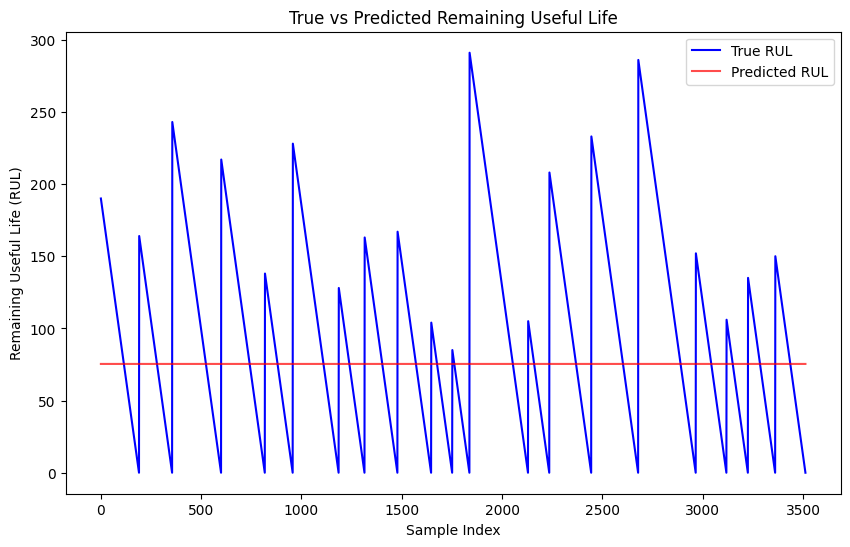

In [122]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test_np, label='True RUL', color='blue')
plt.plot(y_pred_np, label='Predicted RUL', color='red', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('True vs Predicted Remaining Useful Life')
plt.legend()
plt.show()


In [36]:
import torch
print(f'Torch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA device count: {torch.cuda.device_count()}')
if torch.cuda.is_available():
    print(f'Active device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
else:
    print('No CUDA devices detected.')

Torch version: 2.9.1+cu128
CUDA available: True
CUDA device count: 1
Active device: NVIDIA GeForce RTX 5060 Ti


In [32]:
import torch
if not torch.cuda.is_available():
    raise SystemExit('CUDA is not available; skipping tensor test.')
device = torch.device('cuda')
x = torch.randn(1000, 1000, device=device)
y = torch.randn(1000, 1000, device=device)
z = torch.matmul(x, y)
print(f'Result tensor device: {z.device}')
print(f'Result sample: {z.flatten()[0].item():.6f}')

Result tensor device: cuda:0
Result sample: 3.887904
